In [ ]:
# In this contribution we use yahoo finance, wiki data and networkx to download the daily stock prices for the list of companies.
# We examine how the comanies are related to each other in average daily stock price.
# Data are downloaded from wiki and yfinance and missing values are imputed by bfill (backward filling) method. 
# There is provided correlation graph of average daily stock price among companies in given time period.
# Company clusters are displayed based on average daily stock price.
# Dependencies in average daily stock prices in given time period are displayed based on their correlation coefficient (treshhold).


In [41]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from ipywidgets import Layout, widgets
from google.colab import output
output.enable_custom_widget_manager()
import math
import matplotlib.dates as md
!pip install yfinance
import yfinance as yf
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mappings 
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("Greys", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("Greys", len(sp500_sub_sectors)).as_hex()))

In [45]:
sp500_table

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [40]:
# S&P500 metadata
sp500_table = payload[0]

# mappings 
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("Greys", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("Greys", len(sp500_sub_sectors)).as_hex()))

In [22]:
# download S&P500 financial data
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval='1d')
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)
prices

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1577836800, endDate = 1640908800
- BRK.B: No data found, symbol may be delisted


,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple Inc.,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe Inc.,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem Inc.,Yum! Brands,Zimmer Biomet,Zebra Technologies,Zions Bancorporation,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,84.517036,28.982893,153.283569,73.785919,78.725601,81.815155,168.809998,83.297447,202.450989,334.429993,...,142.405029,58.290573,60.554615,55.652870,77.520615,97.649071,142.187546,259.140015,48.681538,131.958664
2020-01-03,83.160049,27.548195,153.293198,73.068573,77.978355,80.786201,166.820007,82.281967,202.113800,331.809998,...,140.292755,58.570904,60.067795,55.037003,77.976906,97.343239,141.815887,256.049988,47.994572,131.978363
2020-01-06,83.405876,27.219410,150.773895,73.650810,78.593742,81.969009,179.039993,82.713058,200.794022,333.709991,...,140.015091,58.486805,60.528996,55.340054,77.472107,97.285881,140.996292,258.010010,47.409737,130.965103
2020-01-07,83.661560,27.119778,148.985352,73.304413,78.145378,81.382416,180.350006,82.253235,196.458878,333.390015,...,140.679504,58.365326,60.033619,55.633316,77.180840,97.457932,140.872421,256.470001,47.121944,131.407806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,157.067200,18.260000,228.445740,175.797409,129.402634,128.717300,352.209991,137.509171,399.651306,569.619995,...,88.879997,65.676071,59.739033,54.988499,116.684036,134.050293,122.545464,582.409973,61.611679,241.255219
2021-12-27,158.002838,18.170000,232.746384,179.836319,130.686081,131.072433,357.829987,139.781876,411.562195,577.679993,...,87.580002,65.883125,60.590763,55.504360,117.468552,136.694839,123.570305,606.330017,62.253880,245.234528
2021-12-28,158.440781,18.540001,234.350510,178.799149,130.666626,131.529556,357.440002,138.803619,411.502747,569.359985,...,86.459999,66.671913,60.394962,55.583717,118.690010,136.665131,123.957039,597.320007,62.352680,242.986237


In [23]:
# Impute the mising values. You can se any method:  ffill, mean, median, ... 
# Bfill (Next Observation Carried Backward (NOCB)) method will replace the past NULL values by values from the next row 
# (if the axis parameter in for rloop is 'row')
for i, row in prices.iterrows():
  if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')
print(prices.shape)

(504, 499)


In [24]:
# calculate the correlation over the 60 days rolling window
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_)

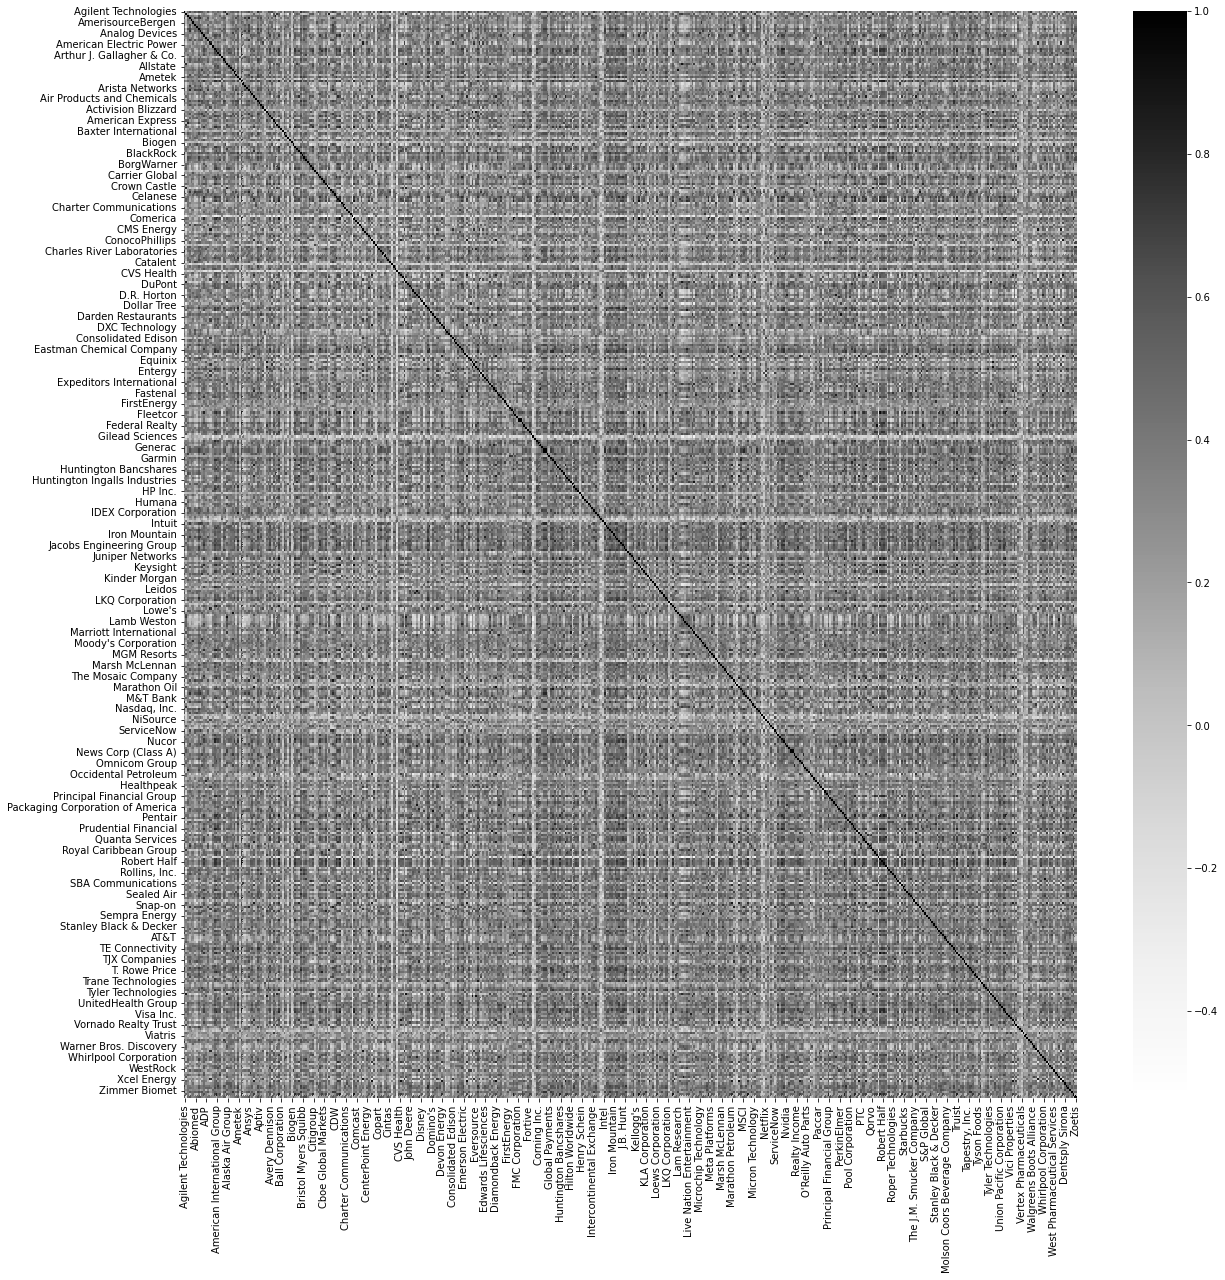

In [27]:
# display correlation coefficients among all companies
plt.figure(figsize=(20,20))
sns.heatmap(corr_, cmap="Greys")

In [64]:
pip install mplcursors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
  Created wheel for mplcursors: filename=mplcursors-0.5.1-py3-none-any.whl size=20820 sha256=892ee52a74823791c4dc9b8156cc9516c825f7663067cd6b39e17c081f72180b
  Stored in directory: /root/.cache/pip/wheels/ae/cd/13/09fe660e3e9d392c7e9b46f202369cd9c2b8dddfb47d5950ef
Successfully built mplcursors


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



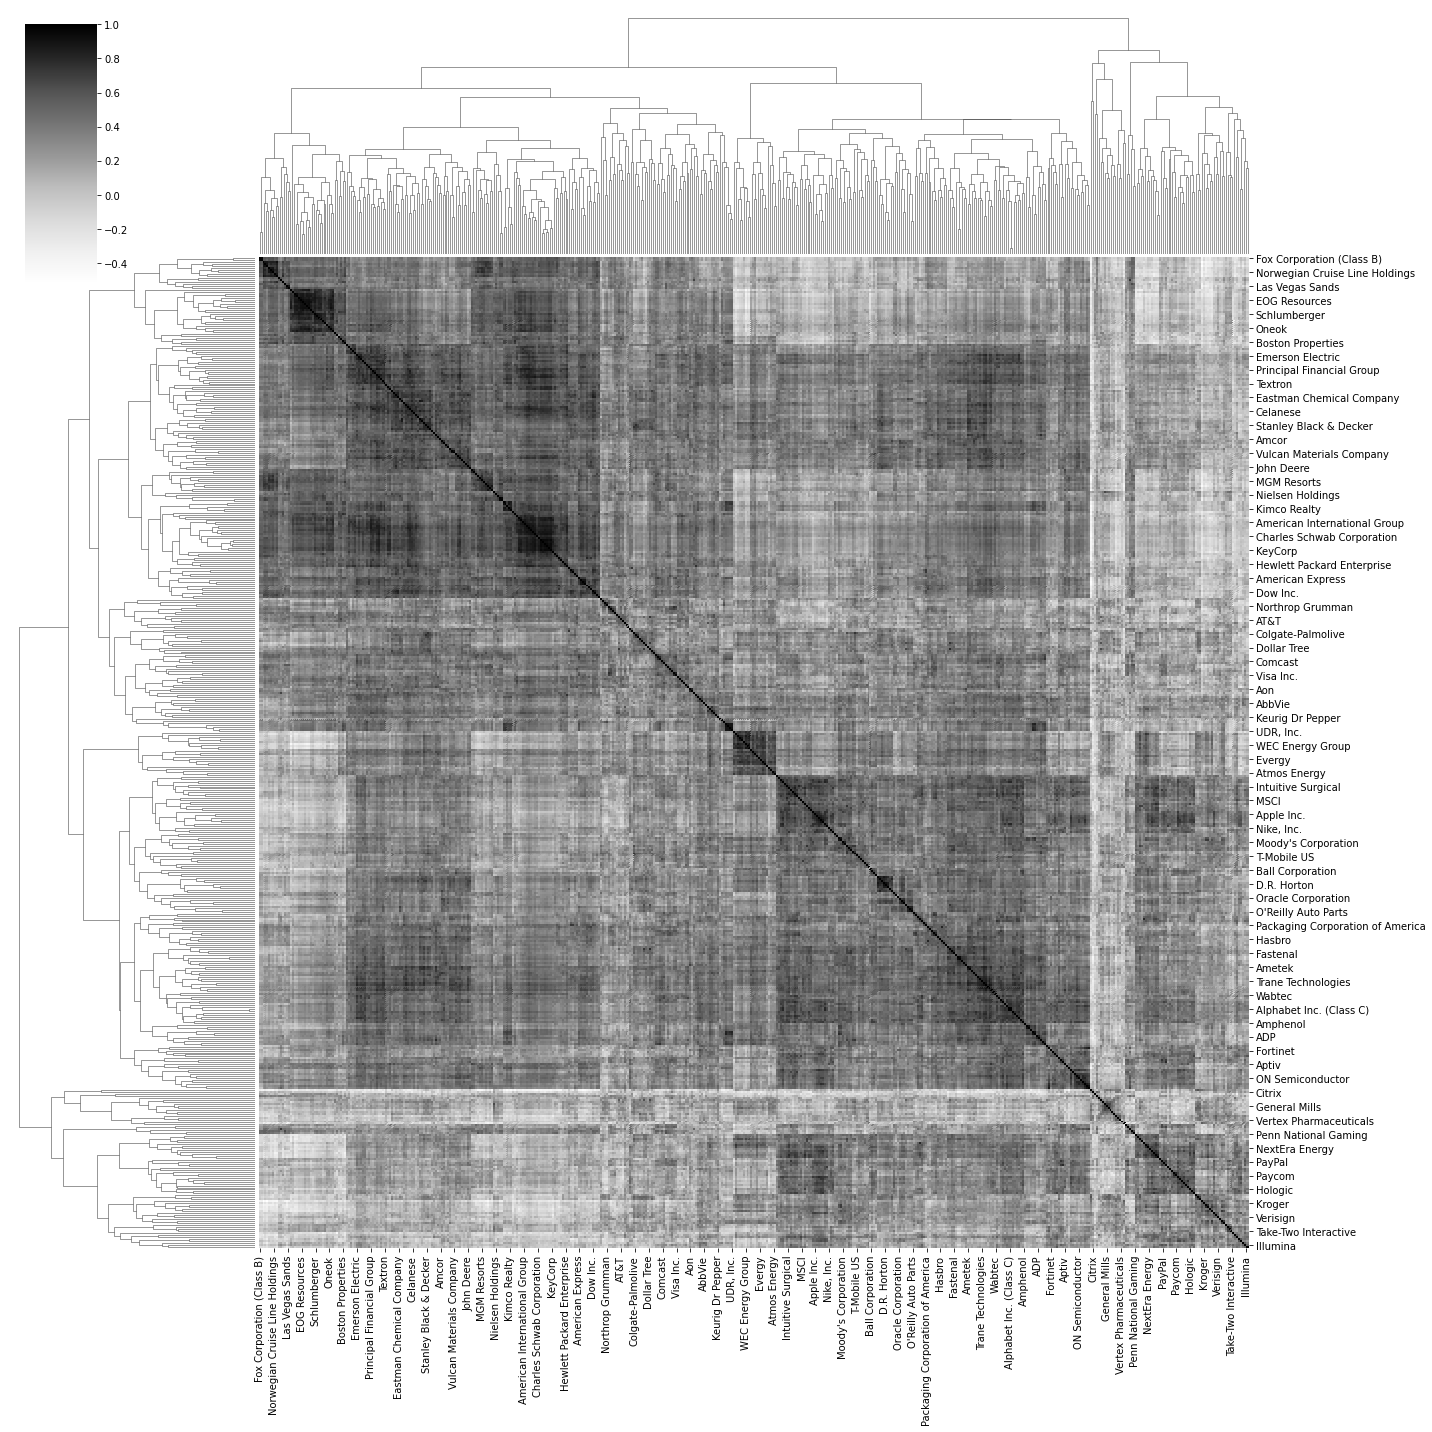

In [30]:
sns.clustermap(corr_, cmap="Greys", figsize=(20,20))

In [48]:
corr_

,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple Inc.,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe Inc.,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem Inc.,Yum! Brands,Zimmer Biomet,Zebra Technologies,Zions Bancorporation,Zoetis
Agilent Technologies,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
American Airlines Group,0.056423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Advance Auto Parts,0.412023,0.186930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Apple Inc.,0.635420,-0.082001,0.422397,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
AbbVie,0.361649,0.061077,0.459161,0.416382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yum! Brands,0.582765,0.151076,0.434749,0.480617,0.438848,0.386315,0.298431,0.336788,0.604988,0.426167,...,0.351723,0.534127,0.175739,0.486772,0.656570,0.000000,0.000000,0.000000,0.000000,0.0
Zimmer Biomet,0.431468,0.321471,0.432653,0.298136,0.260289,0.335028,0.329800,0.289508,0.350675,0.157139,...,0.415891,0.279229,0.313488,0.667776,0.374305,0.416808,0.000000,0.000000,0.000000,0.0
Zebra Technologies,0.715379,0.142833,0.394681,0.571811,0.454562,0.467261,0.531049,0.483845,0.619917,0.498233,...,0.343611,0.169482,0.300865,0.302291,0.533732,0.571479,0.304368,0.000000,0.000000,0.0
Zions Bancorporation,0.230545,0.533762,0.386273,0.077388,0.347840,0.435396,0.098800,0.031881,0.379860,-0.062934,...,0.535592,0.091271,0.707414,0.469045,0.359668,0.392853,0.352747,0.414464,0.000000,0.0


In [75]:
# create treshold slider and network figure and display the multicolinearity
# we can set optimal node distance to k=2.5


# we display the result with help of fruchterman reingold layout algorithm
# fruchterman reingold layout can minimize the error finding the eqilibrium (attraction) between attractive and repellig force
# fruchterman reingold layout is designed for social networks

# maximum spanning tree - spanning tree with weight greater than or equal to the weight of every other spanning tree. 
# we find MST by Prim, Kruskal or Boruvka algorithm after multiplying the edge weights by -1.

# kruskal algorithm - adds the next lowest-weight edge that will not form a cycle to the minimum spanning forest

# triu indices - upper triangular part of matrix in an array



threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.02, continuous_update=False, 
                                       orientation='horizontal', layout=Layout(width='500px'), style=dict(description_width= 'initial'))
network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='Grey',width=2),
                                           marker=dict(size=5, line_width=3,line=dict(color='Grey',width=2))),
                                go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", 
                                          text=[],hoverinfo='text',textfont_size=12, marker=dict(size=5, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0),width=800, height=400))
df = prices.copy()
correlation_matrix = corr_.to_numpy()

def plot_corr_graph(change):
    threshold, corr_mode = None, None
    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0
    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)
    remove = []
    
    for col1, col2, weight in G.edges(data=True):
      if math.isnan(weight["weight"]):
        remove.append((col1,col2))
    
      if abs(weight["weight"]) < threshold:
        remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))
    
    for node in G.nodes:
      if node not in edges:
        remove.append(node)
    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)
    
    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]
    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"
    edge_colors = []
    node_colors = []
    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
    for key, value in dict(mst.degree).items():
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice, network])

In [76]:
network

FigureWidget({
    'data': [{'line': {'color': 'Grey', 'width': 2},
              'marker': {'line': {'color':…

In [ ]:
# you can revise the values of MST

correlation_matrix = corr_.to_numpy()
G = nx.from_numpy_matrix(correlation_matrix)
T = nx.maximum_spanning_tree(G)
sorted(T.edges(data=True))